# Vibstand data
This notebook demonstrates the power of using topology in bearing fault detection tasks on laboratory data

In [1]:
#imports
import numpy as np
import pandas as pd
import gudhi as gd
from gudhi.representations import BettiCurve
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances, silhouette_score
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from tqdm.notebook import tqdm 
import matplotlib
import h5py
from TDASignaltools import cvb, compute_diagram
from scipy.signal import spectrogram


In [2]:
#load data
datapath ="./dane vibstand/"
filelist = os.listdir(datapath)
print(sorted(filelist))
filenames  =sorted(filelist)
df_list = []
for filename in sorted(filelist):
    f = h5py.File(datapath +filename,'r')
    data_names = np.array(f.get('/'))
    dictionary = {}
    for i in range(0,len(data_names)-1):
        name = data_names[i]
        dictionary.update({name : np.array(f.get('/'+name)).T[0]})
    df = pd.DataFrame.from_dict(dictionary)
    df_list.append(df)

['speed_10.mat', 'speed_15.mat', 'speed_20.mat', 'speed_25_5.mat']


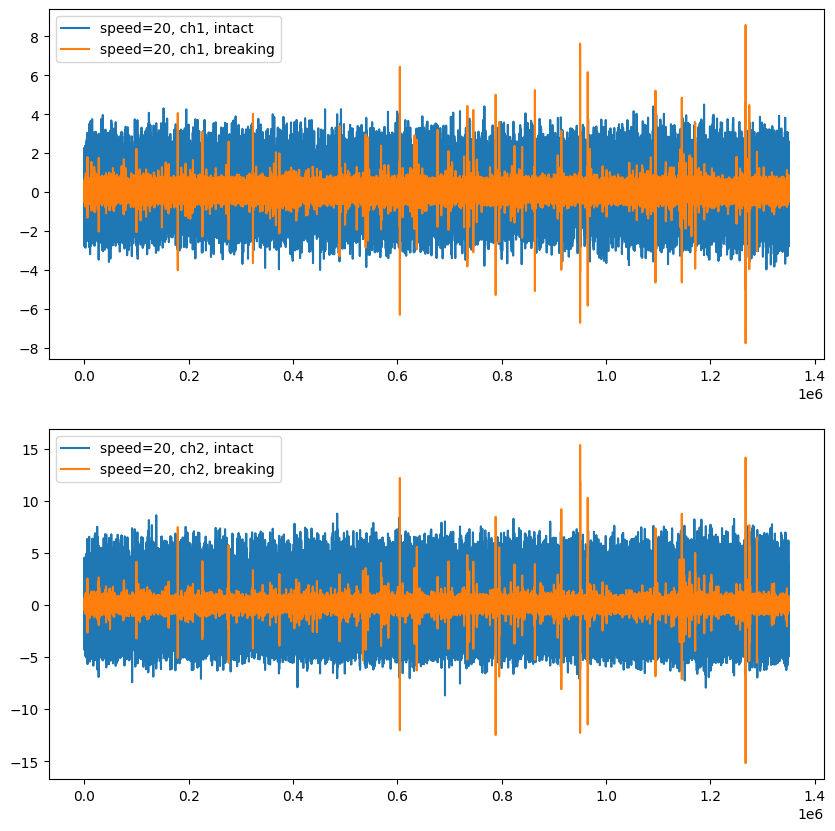

In [3]:
df = df_list[3]
f,ax = plt.subplots(2,1, figsize =(10,10))
ax[0].plot(df["Vib1"], label="speed=20, ch1, intact")
ax[0].plot(df["Vib3"], label="speed=20, ch1, breaking")
ax[1].plot(df["Vib2"], label="speed=20, ch2, intact")
ax[1].plot(df["Vib4"], label="speed=20, ch2, breaking")
ax[0].legend()
ax[1].legend()
plt.show()

In [4]:
#betti curves

n_samples = 10
start = 2.98
end = 3.7
grid = np.linspace(start,end,257)
bc = BettiCurve(predefined_grid=grid)
betti_curves = np.zeros((4,4,n_samples,len(grid)))

speeds = [10,15,20,25]


for j in tqdm(range(0,len(df_list))):
    scaling_factor =(j+2)*0.5    
    dim = int(90*(1/(scaling_factor)))
    delay = 120
    
    print("Speed {}, dim = {}, delay = {}".format(speeds[j],dim,delay))
    
    skip =1
    for i in range(0,4):
        samples = np.array_split(df_list[j].iloc[:,i].values,n_samples)
        
        for k in range(0,len(samples)):
            pd = compute_diagram(samples[k], dim, delay, skip, normalize = True, weighted = True, point_cloud_size = 250)

            curve = np.array(bc.fit_transform([pd])[0])
            betti_curves[j,i,k] = curve


  0%|          | 0/4 [00:00<?, ?it/s]

Speed 10, dim = 90, delay = 120
Speed 15, dim = 60, delay = 120
Speed 20, dim = 45, delay = 120
Speed 25, dim = 36, delay = 120


In [5]:
#cvb

n_samples = 10
cvb_curves = np.zeros((4,4,n_samples,257))




for j in tqdm(range(0,len(df_list))):

    for i in range(0,4):
        samples = np.array_split(df_list[j].iloc[:,i].values,n_samples)
        
        for k in range(0,len(samples)):
            freqs, t, Pxx = spectrogram(samples[k], fs=25000, nfft=512, window="hamming", nperseg= 256, noverlap= int(np.floor(0.85*256)),detrend = False, mode="magnitude")
            curve =  np.array([cvb(np.abs(Pxx[i])) for i in range(0,len(freqs))])

            cvb_curves[j,i,k] = curve

  0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
#uncomment one of the following three lines depending on whether you are interested in Betti curve, CVB or a combination
curves = betti_curves
#curves = cvb_curves
#curves = np.concatenate([betti_curves, (np.max(betti_curves)/np.max(cvb_curves))*cvb_curves],axis = 3)
norms = np.zeros((len(df_list),4,n_samples))
for i in range(len(df_list)):
    for j in range(4):
        for k in range(n_samples):
            norms[i,j,k] = np.sum(np.abs(curves[i,j,k]))

  0%|          | 0/4 [00:00<?, ?it/s]

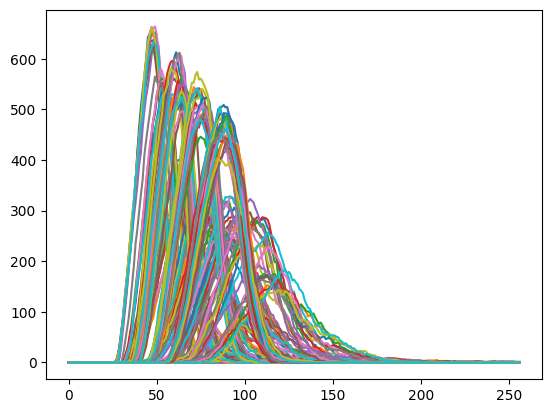

In [7]:
#plot the curves
f,ax = plt.subplots()
for j in tqdm(range(0,len(df_list))):
    for i in range(0,4):
        for k in range(0,len(samples)):
            ax.plot(curves[j,i,k])
plt.show()

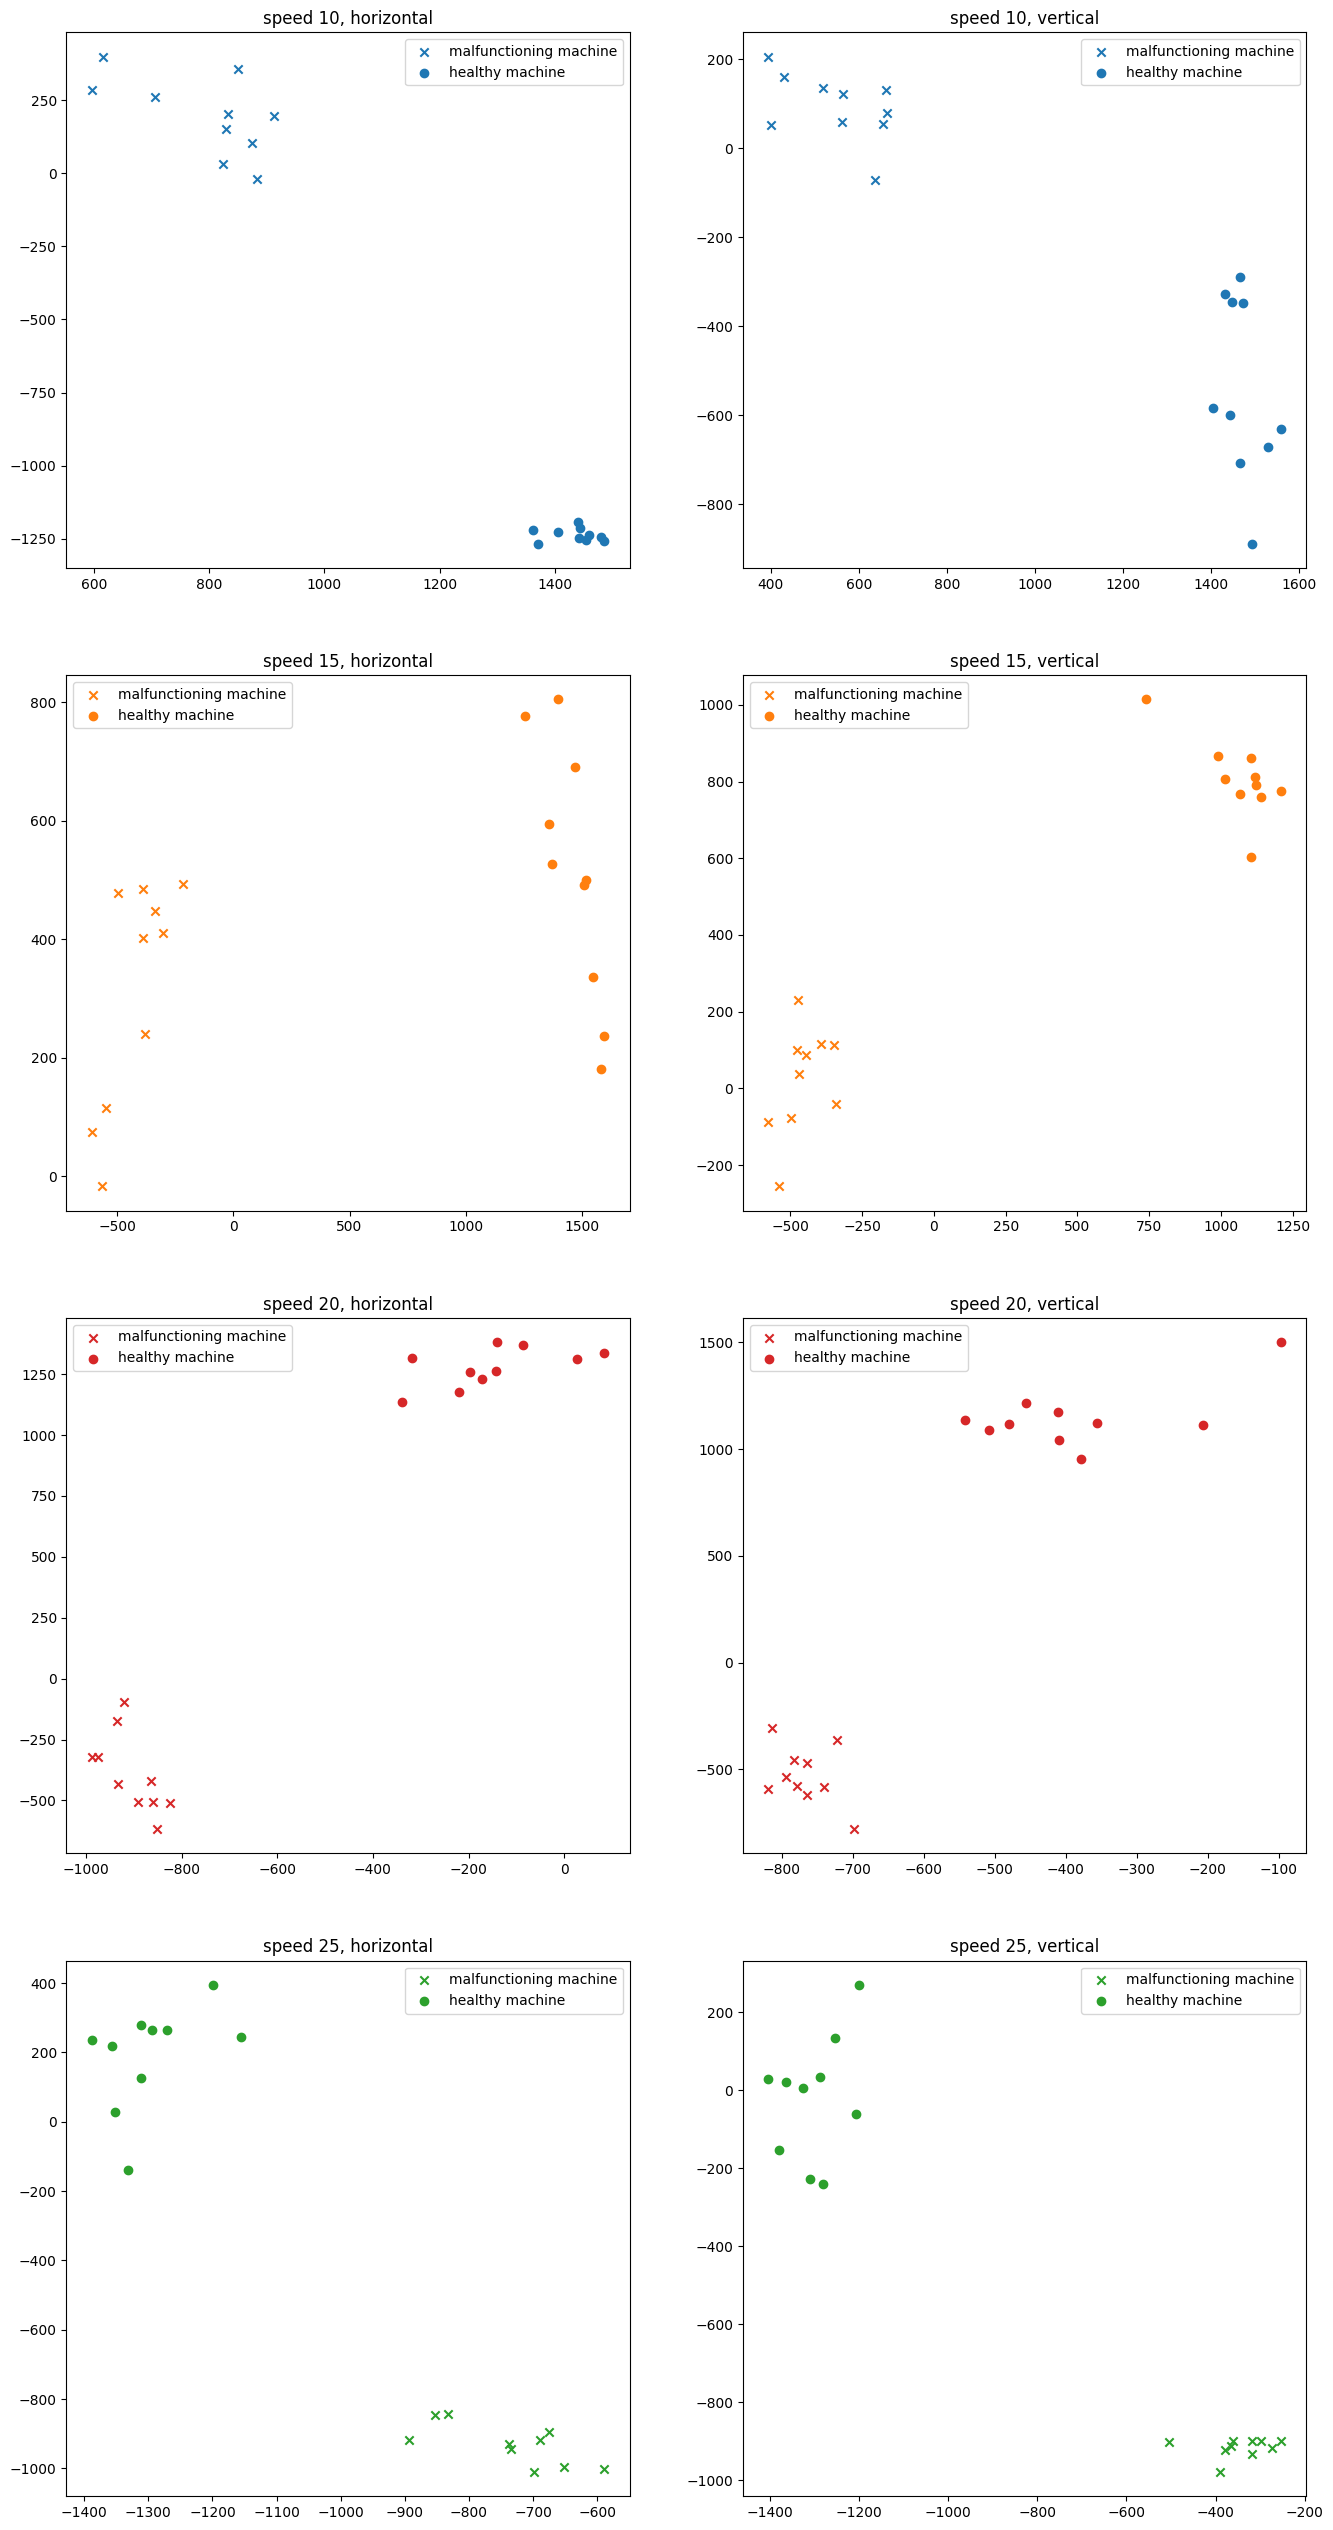

[0.52229033 0.29721673 0.10682732]


In [8]:
#pca
pca = PCA(n_components=3)
pca.fit_transform([betti_curves[j,i,k] for j in range(0,4) for i in range(0,4) for k in range(0,n_samples)])

fig,ax = plt.subplots(4,2,figsize=(16,32))
colors = ["tab:blue", "tab:orange", "tab:red", "tab:green"]
##############Horizontal:0,2 ----------Vertical:1,3
for i in range(0,4):
    emb_bad_h = pca.transform(betti_curves[i,0,:])
    emb_good_h = pca.transform(betti_curves[i,2,:])
    ax[i,0].scatter(emb_bad_h[:,0],emb_bad_h[:,1], marker = "x", c=colors[i], label="malfunctioning machine")
    ax[i,0].scatter(emb_good_h[:,0],emb_good_h[:,1], marker = "o", c=colors[i], label="healthy machine")
    ax[i,0].set_title("speed {}, horizontal".format(speeds[i]))
    ax[i,0].legend()
    emb_bad_v = pca.transform(betti_curves[i,1,:])
    emb_good_v = pca.transform(betti_curves[i,3,:])
    ax[i,1].scatter(emb_bad_v[:,0],emb_bad_v[:,1], marker = "x", c=colors[i], label="malfunctioning machine")
    ax[i,1].scatter(emb_good_v[:,0],emb_good_v[:,1], marker = "o", c=colors[i], label="healthy machine")
    ax[i,1].set_title("speed {}, vertical".format(speeds[i]))
    ax[i,1].legend()


plt.show()
print(pca.explained_variance_ratio_)

speed 10, horizontal: malfunctioning avg l2 norm = 8985.0, std = 440.4790573909275
speed 10, horizontal: helathy avg l2 norm = 11728.7, std = 278.1988677187598
speed 10, vertical: malfunctioning avg l2 norm = 7793.5, std = 309.23753006386534
speed 10, vertical: helathy avg l2 norm = 10492.3, std = 362.9380250125357
speed 15, horizontal: malfunctioning avg l2 norm = 9303.3, std = 630.9762356856239
speed 15, horizontal: helathy avg l2 norm = 12868.3, std = 457.76807446566215
speed 15, vertical: malfunctioning avg l2 norm = 7971.5, std = 609.9785651971715
speed 15, vertical: helathy avg l2 norm = 12187.8, std = 378.61558340881845
speed 20, horizontal: malfunctioning avg l2 norm = 10088.6, std = 536.005634298745
speed 20, horizontal: helathy avg l2 norm = 13474.9, std = 374.1778855036732
speed 20, vertical: malfunctioning avg l2 norm = 8873.6, std = 421.6989921733274
speed 20, vertical: helathy avg l2 norm = 13338.5, std = 706.6319055915887
speed 25, horizontal: malfunctioning avg l2 norm 

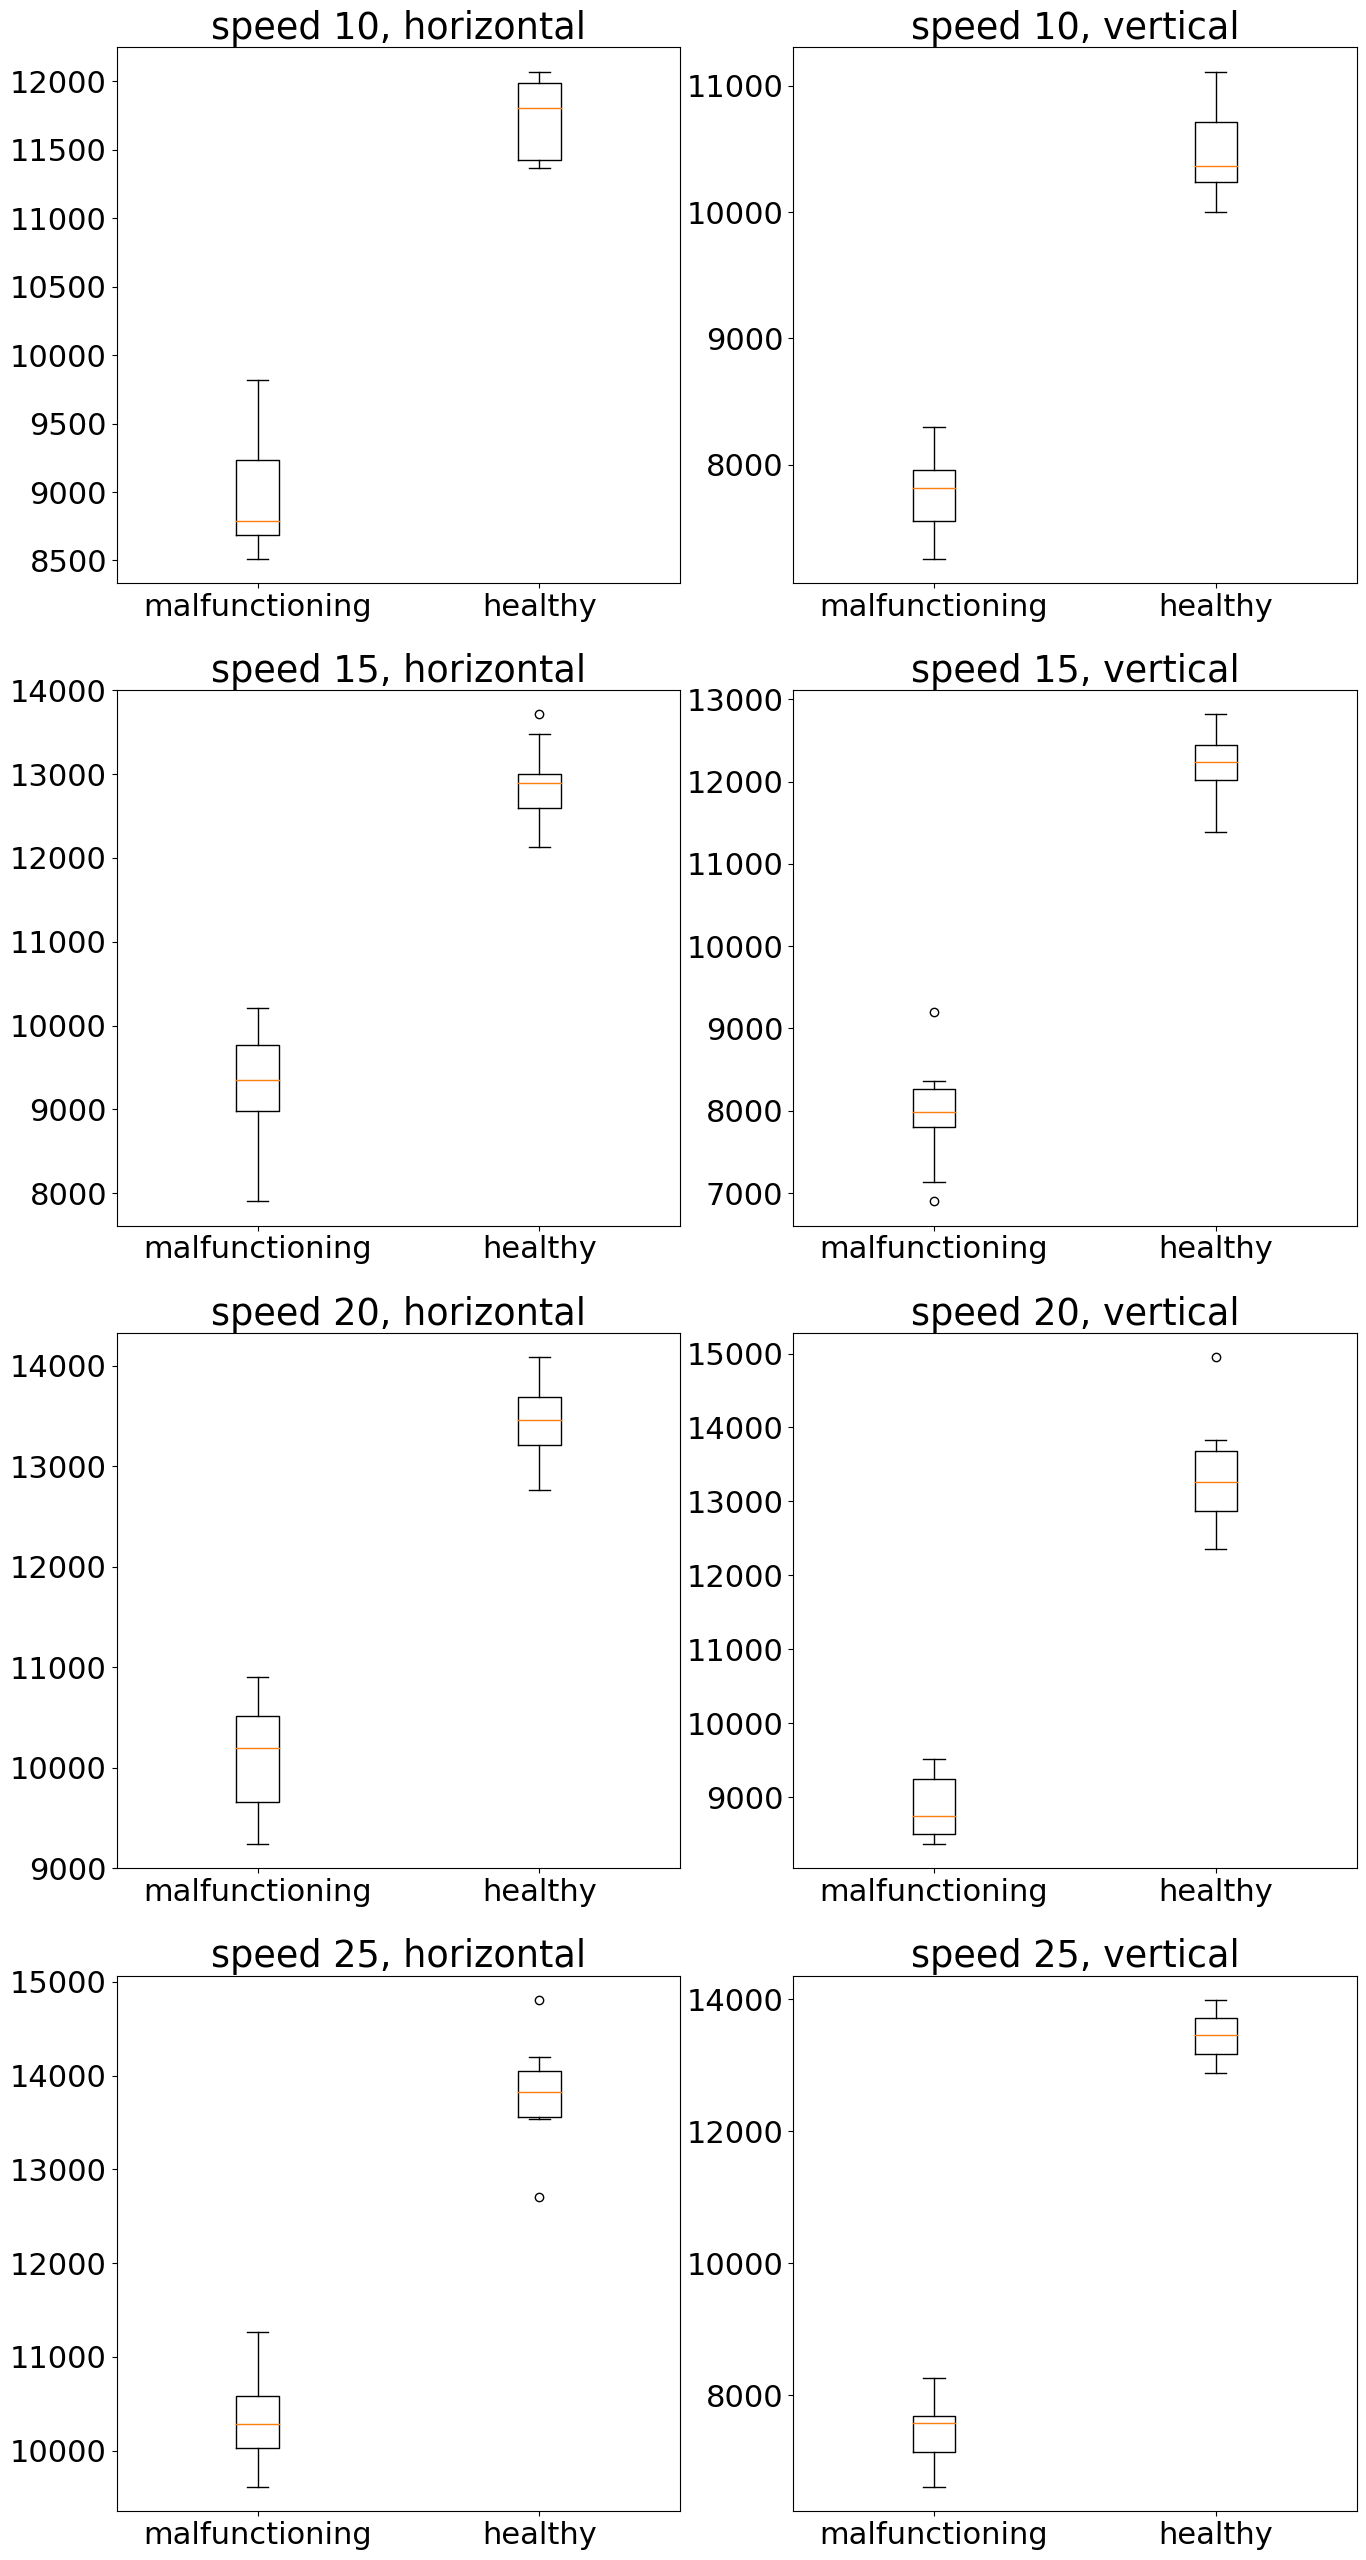

In [9]:
# boxplot of norms
plt.rc('font', **{'size'   : 22})

fig,ax = plt.subplots(4,2,figsize=(16,32))

##############Horizontal:0,2 ----------Vertical:1,3
for i in range(0,4):
    ax[i,0].boxplot([norms[i,0,:],norms[i,2,:]])
    ax[i,0].set_title("speed {}, horizontal".format(speeds[i]))
    ax[i,0].set_xticklabels(["malfunctioning", "healthy"])
    
    ax[i,1].boxplot([norms[i,1,:],norms[i,3,:]])
    ax[i,1].set_title("speed {}, vertical".format(speeds[i]))
    ax[i,1].set_xticklabels(["malfunctioning", "healthy"])

    print("speed {}, horizontal: malfunctioning avg l2 norm = {}, std = {}".format(speeds[i], np.mean(norms[i,0,:]), np.std(norms[i,0,:]) ))
    print("speed {}, horizontal: helathy avg l2 norm = {}, std = {}".format(speeds[i], np.mean(norms[i,2,:]), np.std(norms[i,2,:]) ))
    print("speed {}, vertical: malfunctioning avg l2 norm = {}, std = {}".format(speeds[i], np.mean(norms[i,1,:]), np.std(norms[i,1,:]) ))
    print("speed {}, vertical: helathy avg l2 norm = {}, std = {}".format(speeds[i], np.mean(norms[i,3,:]), np.std(norms[i,3,:]) ))
          
          
#fig.suptitle("L1 norms")
plt.savefig("results/TestRigBoxplot.pdf")

plt.show()

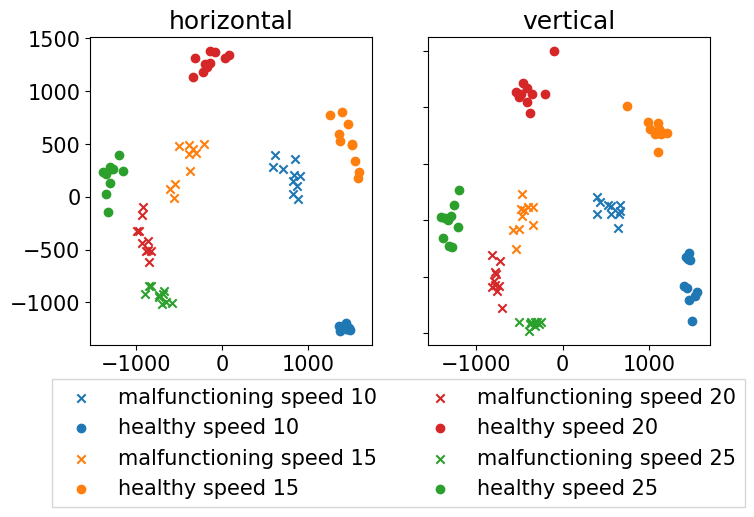

In [10]:
# pca in common axis

pca = PCA(n_components=3)
pca.fit_transform([betti_curves[j,i,k] for j in range(0,4) for i in range(0,4) for k in range(0,n_samples)])
plt.rc('font', **{'size'   : 15})

fig,ax = plt.subplots(1,2,figsize=(8,4))
colors = ["tab:blue", "tab:orange", "tab:red", "tab:green"]
##############Horizontal:0,2 ----------Vertical:1,3
for i in range(0,4):
    emb_bad_h = pca.transform(betti_curves[i,0,:])
    emb_good_h = pca.transform(betti_curves[i,2,:])
    ax[0].scatter(emb_bad_h[:,0],emb_bad_h[:,1], marker = "x", c=colors[i], label="malfunctioning speed {}".format(speeds[i]))
    ax[0].scatter(emb_good_h[:,0],emb_good_h[:,1], marker = "o", c=colors[i], label="healthy speed {}" .format(speeds[i]))
    ax[0].set_title("horizontal")
    emb_bad_v = pca.transform(betti_curves[i,1,:])
    emb_good_v = pca.transform(betti_curves[i,3,:])
    ax[1].scatter(emb_bad_v[:,0],emb_bad_v[:,1], marker = "x", c=colors[i], label="malfunctioning machine {}".format(speeds[i]))
    ax[1].scatter(emb_good_v[:,0],emb_good_v[:,1], marker = "o", c=colors[i], label="healthy machine {}".format(speeds[i]))
    ax[1].set_title("vertical")


ax[1].set_yticklabels([])
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.51, 0.05),
          fancybox=False, shadow=False, ncol=2, prop={"size":15})

#fig.suptitle("PCA from Betti Curves, explained variance:{}".format(pca.explained_variance_ratio_))
plt.savefig("results/TestRigPCA.pdf", bbox_inches="tight")

plt.show()

#print()

In [11]:
def split_score(X,y, test_size, seed):
    clf = SVC(kernel="linear")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)
    #print(y_train.sum(), y_test.sum())
    clf.fit(X_train, y_train)
    return np.array([clf.score(X_test, y_test), np.linalg.norm(clf.coef_[0])])

#SVM classification
n_iterations = 100
score_list = []
svnorm_list = []
for j in range(len(speeds)):
    X=np.array([cvb_curves[j,i,k] for i in range(0,4) for k in range(0,n_samples)])
    y = np.repeat([0,1], 2*n_samples)
    results = Parallel(n_jobs=-1)(delayed(split_score)(X,y, 0.5, i) for i in range(n_iterations))
    results = np.array(results).T
    local_score_list = results[0]
    local_svnorm_list = results[1]
    
    score_list.append(np.array(local_score_list))
    svnorm_list.append(np.array(local_svnorm_list))


1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0


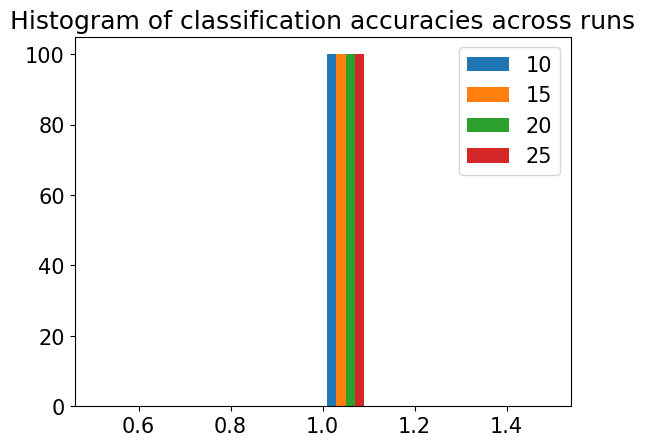

In [12]:
plt.hist(score_list, label=speeds)
plt.legend()
plt.title("Histogram of classification accuracies across runs")

for i in range(len(score_list)):
    print(np.mean(score_list[i]),np.std(score_list[i]))

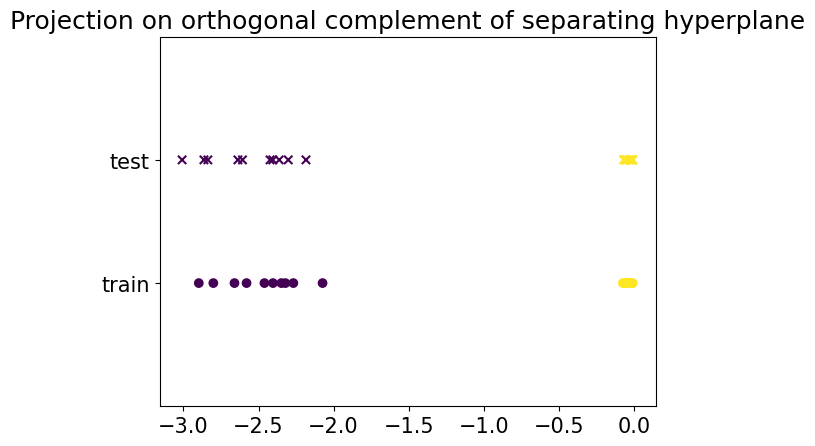

In [13]:
clf = SVC(kernel="linear")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=i, stratify=y)
clf.fit(X_train, y_train)
f,ax = plt.subplots()
projection = np.dot(X_train, clf.coef_[0])
ax.scatter(projection, [0]*2*n_samples, c=y_train)
projection = np.dot(X_test, clf.coef_[0])
ax.scatter(projection, [0.1]*2*n_samples, c=y_test, marker="x")

ax.set_ylim((-0.1,0.2))
ax.set_yticks([0,0.1])
ax.set_yticklabels(["train","test"])

plt.title("Projection on orthogonal complement of separating hyperplane")
plt.show()